In [8]:
#TODO
#lqr controller plotting
#potentially fix with upgrade of tensorflow?? check current version first in case want to revert.


#notes
#already integrated lqr control and plotting is working. cleaned up to make code more concise. interpretations pasted at end


In [5]:
# the tensorflow version of the wong/wang dynamics that only uses a TF version of the controller
#the rest is in numpy
import numpy as np
import matplotlib.pyplot as plt
import math
from tf_funs import * #EKF, and helper in tensorflow
from threechoice_dynamics import * #the gradients for wong/wang dynamics
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy.linalg import solve_discrete_are


true_nontf = lambda x,c: grad_threechoice(x[0],x[1],dt,c)
target_nontf = lambda x: grad_threechoice_healthy(x[0],x[1],dt)   

In [6]:
print(tf.__version__) #1.15.0

1.15.0


Using mean-only control


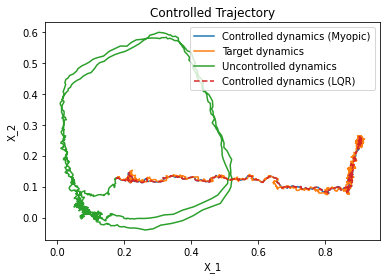

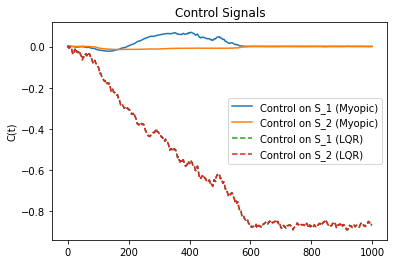

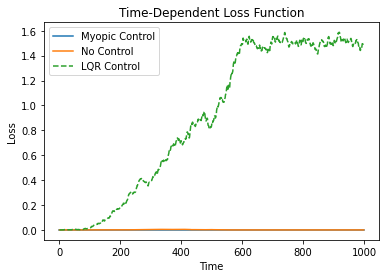

In [7]:


pi = math.pi

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=4,
      inter_op_parallelism_threads=4)
sess = tf.Session(config=session_conf)

# Define the LQR Controller Class
class LQRController:
    def __init__(self, A, B, Q, R):
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.K = self.calculate_lqr_gain()

    def calculate_lqr_gain(self):
        # Solve the Riccati equation
        P = solve_discrete_are(self.A, self.B, self.Q, self.R)
        # Calculate the LQR gain
        K = np.linalg.inv(self.R + self.B.T @ P @ self.B) @ (self.B.T @ P @ self.A)
        return K

    def calculate_control(self, x):
        # Calculate the control signal
        u = -self.K @ x
        return u

    def apply_control(self, x, x_target):
        # Calculate the state error
        error = x - x_target
        # Get the control signal
        control_signal = self.calculate_control(error)
        return control_signal


# Define system dynamics matrices for LQR
A = np.array([[1.0, 0.1], [0, 1.0]])  # Example system matrix
B = np.array([[0.0], [0.1]])          # Example input matrix
Q = np.eye(2)                         # State cost matrix
R = np.eye(1)                         # Control cost matrix

# Initialize the LQR controller
lqr_controller = LQRController(A, B, Q, R)

# Build graphs
xdim = 2  # State dimension
udim = 2  # Control dimension
X_est = tf.placeholder(shape=(xdim), dtype=tf.float32, name='X_est')  # State estimate
PI_est = tf.placeholder(shape=(xdim, xdim), dtype=tf.float32, name='PI_est')  # Estimated covariance
Y_tp1 = tf.placeholder(shape=(xdim), dtype=tf.float32, name='Y_tp1')  # Most recent observation
Control = tf.placeholder(shape=(udim), dtype=tf.float32, name='Control')

# Define the noise for the system
dt = 1.0e-4
gamma = 1.0e-4
sigsstate = (1./dt)*(1e-9)
sigsobs = 1e-6

Q_tf = tf.constant(sigsstate * np.eye(xdim), dtype=tf.float32, name='Q')  # State noise covariance
R_tf = tf.constant(sigsobs * np.eye(xdim), dtype=tf.float32, name='R')  # Observation noise covariance

# Define your dynamics and other graphs...
true_model_est = grad_threechoice_tf(X_est[0], X_est[1], dt, Control)
true_model_est_null = grad_threechoice_tf(X_est[0], X_est[1], dt, [0., 0.])  # State est. gradient null control
target_model_est = grad_threechoice_healthy_tf(X_est[0], X_est[1], dt)  # State est. target dynamics

X_plus, PI_plus = EKF(X_est, Y_tp1, PI_est, true_model_est, true_model_est_null, Q_tf, R_tf, xdim, dt)

# Myopic controller
useMO = 1
if useMO == 1:
    print('Using mean-only control')
    Cnew = myopicController_meanonly(X_est, PI_est, Control, gamma, true_model_est, true_model_est_null, target_model_est, xdim, udim)
else:
    print('Using full myopic control, but non-Jacobian-differential form')
    Cnew = myopicController_noBdiff(X_est, PI_est, Control, gamma, true_model_est, true_model_est_null, target_model_est, xdim, udim)

# Covariance prediction update graph
Ak = dynamics_linearized(X_est, true_model_est_null, xdim)

# The full loss function, not just loss of mean values
loss_tf = loss_full(X_est, PI_est, true_model_est, target_model_est)

# Begin specifics of the simulation
T = 1000  # Number of steps
ns = 1  # Number of samples

# Make the numpy version of noise
statenoise = np.random.normal(0, sigsstate ** 0.5, [xdim, T, ns])
obsnoise = np.random.normal(0, sigsobs ** 0.5, [xdim, T, ns])
G = dt ** 0.5 * np.eye(xdim)  # System noise matrix, for covariance prediction

# Vectors of interest
x_estvec = np.zeros((xdim, T, ns))  # State estimate
x_ucvec = np.zeros((xdim, T, ns))  # Uncontrolled state
xvec = np.zeros((xdim, T, ns))  # Actual controlled state
yvec = np.zeros((xdim, T, ns))  # Observations related to state
x_targvec = np.zeros((xdim, T, ns))  # Target state
PI_estvec = np.zeros((xdim, xdim, T, ns))  # Estimated covariance
contall = np.zeros((udim, T, ns))  # Control

# Initialize arrays to store LQR controller data
contall_lqr = np.zeros((udim, T, ns))
x_estvec_lqr = np.zeros((xdim, T, ns))  # LQR state estimate
loss_lqr = np.zeros((4, T, ns))  # LQR loss

# Loss function values in vector form as (full loss, mean-only loss, jacobian loss term, Hessian term)
loss = np.zeros((4, T, ns))
loss_nocont = np.zeros((4, T, ns))
loss_true = np.zeros((T, ns))
initvals = np.zeros((xdim, ns))

lag = 1  # 1+number of steps difference between observations and state estimate

init = tf.global_variables_initializer()

for m in range(ns):
    sess.run(init)
    x_init = np.random.uniform(0.1, 0.2, (2,))
    initvals[:, m] = x_init
    PI_init = [[1.0e-6, 0.], [0., 1.0e-6]]  # Initial covariance
    c_init = [0., 0.]

    xest_k = x_init
    pi_k = PI_init
    c_k = c_init
    x_k = x_init
    x_targ_k = x_init
    ykp1 = np.array(x_init)

    x_estvec[:, 0, m] = x_init
    xvec[:, 0, m] = x_init
    x_ucvec[:, 0, m] = x_init
    x_targvec[:, 0, m] = x_init
    PI_estvec[:, :, 0, m] = PI_init
    x_estvec_lqr[:, 0, m] = x_init

    # Propagate lag-steps ahead before starting state estimation
    for k in range(1, lag):
        # Update actual dynamics
        grad_cont = true_nontf(xvec[:, k - 1, m], c_init)
        grad_targ = target_nontf(x_targvec[:, k - 1, m])
        grad_uc = true_nontf(x_ucvec[:, k - 1, m], c_init)

        xvec[:, k, m] = xvec[:, k - 1, m] + grad_cont + statenoise[:, k, m]
        x_ucvec[:, k, m] = x_ucvec[:, k - 1, m] + grad_uc + statenoise[:, k, m]
        x_targvec[:, k, m] = x_targvec[:, k - 1, m] + grad_targ + statenoise[:, k, m]
        yvec[:, k, m] = xvec[:, k, m] + obsnoise[:, k, m]

        # Set estimates in beginning lags to initial state
        x_estvec[:, k, m] = x_init
        PI_estvec[:, :, k, m] = PI_init
        x_estvec_lqr[:, k, m] = x_init

    for k in range(max(1, lag), T): 
        # Update actual dynamics
        grad_cont = true_nontf(xvec[:, k - 1, m], contall[:, k - 1, m])
        grad_uc = true_nontf(x_ucvec[:, k - 1, m], c_init)
        grad_targ = target_nontf(x_targvec[:, k - 1, m])
        xvec[:, k, m] = xvec[:, k - 1, m] + grad_cont + statenoise[:, k, m]
        x_ucvec[:, k, m] = x_ucvec[:, k - 1, m] + grad_uc + statenoise[:, k, m]
        x_targvec[:, k, m] = x_targvec[:, k - 1, m] + grad_targ + statenoise[:, k, m]
        yvec[:, k, m] = xvec[:, k, m] + obsnoise[:, k, m]

        # Run state estimator to update estimate of state k-lag
        test = sess.run([X_plus, PI_plus],
                        {X_est: x_estvec[:, k - lag, m], 
                         PI_est: PI_estvec[:, :, k - lag, m], 
                         Control: contall[:, k - lag, m], Y_tp1: yvec[:, k - lag + 1, m]})
        x_estvec[:, k - lag + 1, m] = test[0]
        PI_estvec[:, :, k - lag + 1, m] = test[1]
        
        # Predict lag states in the future to calculate control
        x_est_n = x_estvec[:, k - lag + 1, m]
        PI_est_n = PI_estvec[:, :, k - lag + 1, m]
        
        for n in range(1, lag):
            # State prediction step
            grad_cont = true_nontf(x_est_n, contall[:, k - lag - n, m])

            # Covariance prediction step. Calculate jacobian
            Ak_n = sess.run(Ak,
                            {X_est: x_est_n, PI_est: PI_est_n,
                             Control: contall[:, 0, m], Y_tp1: yvec[:, 0, m]})

            x_est_n = x_est_n + grad_cont
            PI_est_n = np.matmul(Ak_n, PI_est_n) + np.matmul(PI_est_n, np.transpose(Ak_n)) + np.matmul(
                np.matmul(G, Q), np.transpose(G))

        # Run myopic controller using predicted state estimate
        c_k_myopic = sess.run(Cnew, {X_est: x_est_n, PI_est: PI_est_n,
                                     Control: contall[:, k - 1, m], Y_tp1: yvec[:, k, m]})
        
        # Run LQR controller
        c_k_lqr = lqr_controller.apply_control(x_est_n, x_targ_k)

        # Store controls and state estimates
        if abs(np.linalg.norm(c_k_myopic)) > 100.:
            contall[:, k, m] = contall[:, k - 1, m]
            print('Dynamics likely got singular. Hold tight')
            print(k)
        else:
            contall[:, k, m] = c_k_myopic
        contall_lqr[:, k, m] = c_k_lqr
        x_estvec_lqr[:, k, m] = x_est_n

        # Calculate LQR loss
        loss_lqr[0, k, m] = np.linalg.norm(true_nontf(x_estvec_lqr[:, k, m], contall_lqr[:, k, m]) -
                                           target_nontf(x_estvec_lqr[:, k, m])) ** 2

        # Calculate true loss from actual state
        loss_true[k - lag + 1, m] = np.linalg.norm(true_nontf(xvec[:, k - lag + 1, m], contall[:, k - lag + 1, m]) -
                                                   target_nontf(xvec[:, k - lag + 1, m])) ** 2

        # Approximated loss from estimated state
        ltest = sess.run(loss_tf, {X_est: x_estvec[:, k - lag + 1, m],
                                   PI_est: PI_estvec[:, :, k - lag + 1, m],
                                   Control: contall[:, k - lag + 1, m]})
        loss[:, k - lag + 1, m] = ltest

        # Approximated loss from estimated state, no control
        ltest = sess.run(loss_tf, {X_est: x_estvec[:, k - lag + 1, m],
                                   PI_est: PI_estvec[:, :, k - lag + 1, m],
                                   Control: np.array([0., 0.])})
        loss_nocont[:, k - lag + 1, m] = ltest
        
    # Set final lag estimate values to estimate
    for k in range(lag - 1):
        x_targvec[:, T - lag + 1 + k, m] = x_targvec[:, T - lag, m]
        x_estvec[:, T - lag + 1 + k, m] = x_estvec[:, T - lag, m]
        x_ucvec[:, T - lag + 1 + k, m] = x_ucvec[:, T - lag, m]
        PI_estvec[:, :, T - lag + 1 + k, m] = PI_estvec[:, :, T - lag, m]
        x_estvec_lqr[:, T - lag + 1 + k, m] = x_estvec_lqr[:, T - lag, m]

# Plotting
# Plot the state trajectories
tind = 0
plt.plot(x_estvec[0, :, tind], x_estvec[1, :, tind], label='Controlled dynamics (Myopic)')
plt.plot(x_targvec[0, :, tind], x_targvec[1, :, tind], label='Target dynamics')
plt.plot(x_ucvec[0, :, tind], x_ucvec[1, :, tind], label='Uncontrolled dynamics')
plt.plot(x_estvec_lqr[0, :, tind], x_estvec_lqr[1, :, tind], label='Controlled dynamics (LQR)', linestyle='--')
plt.legend()
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.title('Controlled Trajectory')
plt.show()

# Plot the control signals
plt.plot(contall[0, :, tind], label='Control on S_1 (Myopic)')
plt.plot(contall[1, :, tind], label='Control on S_2 (Myopic)')
plt.plot(contall_lqr[0, :, tind], label='Control on S_1 (LQR)', linestyle='--')
plt.plot(contall_lqr[1, :, tind], label='Control on S_2 (LQR)', linestyle='--')
plt.ylabel('C(t)')
plt.title('Control Signals')
plt.legend()
plt.show()

# Plot the loss function
plt.plot(loss[0, :, tind], label='Myopic Control')
plt.plot(loss_nocont[0, :, tind], label='No Control')
plt.plot(loss_lqr[0, :, tind], label='LQR Control', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Time-Dependent Loss Function')
plt.legend()
plt.show()



Let's interpret the graphs one by one based on the plots you've provided:

1. Loss Function Over Time
Y-axis: Loss (could be a measure of deviation from the target state).
X-axis: Time steps.
Lines:
Blue (Myopic Control): The myopic controller's loss over time.
Orange (No Control): The loss without any control applied.
Green Dashed (LQR Control): The LQR controller's loss over time.
Interpretation:
The LQR controller (green dashed line) shows an increase in loss initially, indicating an adjustment phase, but it stabilizes and maintains a higher level of loss compared to the myopic control.
The myopic control (blue line) starts with low loss and maintains it throughout the time steps.
The no control (orange line) maintains a constant loss, indicating no improvement over time.
2. Control Signals Over Time
Y-axis: Control signal values (C(t)).
X-axis: Time steps.
Lines:
Blue (Control on S_1, Myopic): Control signal for the first state dimension using the myopic controller.
Orange (Control on S_2, Myopic): Control signal for the second state dimension using the myopic controller.
Green Dashed (Control on S_1, LQR): Control signal for the first state dimension using the LQR controller.
Red Dashed (Control on S_2, LQR): Control signal for the second state dimension using the LQR controller.
Interpretation:
The LQR control signals (green dashed and red dashed lines) show a decreasing trend over time, indicating that the LQR controller is applying less control effort as time progresses.
The myopic control signals (blue and orange lines) are more stable, with slight variations indicating consistent control application throughout the time steps.
There is a significant difference in the control signals applied by the LQR and myopic controllers, which might explain the differences in their performance.
3. State Trajectories
X-axis: First state dimension (X_1).
Y-axis: Second state dimension (X_2).
Lines:
Blue (Controlled dynamics, Myopic): State trajectory using the myopic controller.
Orange (Target dynamics): Target state trajectory.
Green (Uncontrolled dynamics): State trajectory without any control applied.
Red Dashed (Controlled dynamics, LQR): State trajectory using the LQR controller.
Interpretation:
The target dynamics (orange line) represent the desired state trajectory.
The uncontrolled dynamics (green line) deviate significantly from the target, showing the natural system behavior without control.
The myopic controlled dynamics (blue line) closely follow the target dynamics, indicating effective control.
The LQR controlled dynamics (red dashed line) initially follow a different path and eventually stabilize, but they do not align as closely with the target dynamics as the myopic controller.
Overall Interpretation:
Myopic Control: Shows consistent and effective control by maintaining low loss, stable control signals, and state trajectories closely following the target dynamics.
LQR Control: Demonstrates higher initial control effort that decreases over time, leading to higher loss and less alignment with the target dynamics compared to the myopic controller.
No Control: Predictably ineffective, with constant loss and uncontrolled state trajectories diverging significantly from the target.
These graphs collectively suggest that the myopic controller is more effective in this scenario, maintaining lower loss and better adherence to the target dynamics with stable control efforts. The LQR controller, while initially aggressive, stabilizes but does not perform as well as the myopic controller in maintaining the desired state trajectory.

## Gain Tuning

Feedback Loop Enhancement: Introduce more sophisticated feedback mechanisms, such as non-linear control laws or gain scheduling, where control parameters change based on the system's state.

State Estimation Accuracy: Improve the accuracy of the state estimation by refining the model used in the EKF. Better state estimation can result in more accurate control actions.

Control Law Modifications: Alter the structure of the control law itself. For example, introduce derivative control to provide damping or use integral control to eliminate steady-state errors.

Adding Heuristics: Include heuristic rules based on domain knowledge that can improve control actions. For instance, if you know certain states are particularly problematic, you could add rules to handle these explicitly.

Learning from Past Performance: Implement a learning mechanism that adjusts control parameters based on past performance. This is not predictive control, but rather a retrospective adjustment to improve future performance.

Noise Filtering: Improve the noise filtering in the observations fed into the control algorithm. If the control input is noisy, it could lead to erratic behavior.

Robust Control Techniques: Employ robust control techniques that are designed to perform well in the face of uncertainty and system variability.

Action Smoothing: If the control action is jumping erratically, introduce a smoothing factor to make changes more gradual and prevent sudden shifts.

Simulation-Based Optimization: Use simulations to optimize the control parameters for the most common scenarios that the system faces.